# Project Milestone P2

### Objective

This notebook is a creative extension concerning the article _Comparing Random Forest with Logistic Regression for
Predicting Class-Imbalanced Civil War Onset Data_ by D.Muchlinski et al (2016).
We aim to TODO

### Libraries

- Scikit-learn
- Numpy
- Pandas
- Matplotlib
- Seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

## 1. Data Loading and preparation

In [2]:
replication_features = ["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]

data = pd.read_csv('data/SambnisImp.csv', usecols=replication_features)

# Retreiving the labels
y = data['warstds']
X = data.drop('warstds', axis=1)

print('Nb of country-years: {}'.format(len(X)))
X.head()

Nb of country-years: 7140


,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,polch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,12,0.005151,118.554791,129472.9042,121.087366,72.881375,4508.131692,0,0,0,...,0.16935,0.313143,0.373714,0.052989,61.493014,0,0,0,0,0.143299
1,24,0.000000,117.756342,129413.0225,121.885359,72.900089,4491.340308,0,0,0,...,0.00000,1.000000,0.000000,0.052663,100.000000,0,0,0,0,1.000000
2,36,0.000000,118.280656,130431.0145,122.780608,72.962880,4484.267686,0,0,0,...,0.00000,1.000000,0.000000,0.052891,100.000000,0,0,0,0,1.000000
3,48,0.000000,118.325869,126781.6866,118.256427,73.102449,4474.082672,0,0,0,...,0.00000,1.000000,0.000000,0.052902,100.000000,0,0,0,0,1.000000
4,60,0.000000,118.312296,130979.2470,122.245074,72.850389,4497.299503,0,0,0,...,0.00000,1.000000,0.000000,0.052706,100.000000,0,0,0,0,1.000000


In [3]:
# We verify no data is missing
len(X[X.isna().any(axis=1)])

0

Let us reproduce Figure 2 from the article, this will serve as a comparison point for our extensions.
In the article, Random Forests are compared to "against three well-known logistic models of civil war onset", namely those developped by:
- Collier and Hoeffler (2004) 
- Fearon and Laitin (2003)
- Hegre and Sambanis (2006).

Let us load the corresponding features.

In [4]:
#Fearon and Laitin (2003) 
FL_features = ["warhist", "ln_gdpen", "lpopns", "lmtnest", "ncontig", "oil",
               "nwstate", "inst3", "pol4", "ef", "relfrac"] 
X_FL = X[FL_features]

#Collier and Hoeffler (2004)
CH_features = ["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth","warhist", "lmtnest",
               "ef", "popdense", "lpopns", "coldwar", "seceduc","ptime"]
X_CH = X[CH_features]

#Hegre and Sambanis (2006) 
HS_features = ["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]
X_HS = X[HS_features]

## 2. Fitting and comparing the models

We will run all three different logistic models through two methods each, namely a regular and a L2-penalized (TODO justify), logistic regressions.

In [5]:
# Creating the methods
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
gbc = GradientBoostingClassifier(random_state=0)
random_forest = RandomForestClassifier(n_estimators=1000)

In [11]:
def plot_multi_roc(titles, methods, datasets, models, random_forest, y):
    """
    Reproduces Figure 2 from the article, i.e. plot ROC curves for each model on their corresponding datasets.
    """
    
    fig, axes = plt.subplots(1,len(methods), figsize=(len(methods)*6.5,5))
    
    for ax, title, method in zip(axes.flatten(), titles, methods):
        for X, model in zip(datasets, models):

            # Predict the probabilities with a cross validation
            if(model == 'Random Forest'):
                y_pred = cross_val_predict(random_forest, X, y, cv=10, method="predict_proba")
            else:
                y_pred = cross_val_predict(method, X, y, cv=10, method="predict_proba")

            # Compute the False Positive Rate and True Positive Rate
            fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
            # Compute the area under the fpt-tpf curve
            auc_score = auc(fpr, tpr)

            # Plotting results
            ax.plot(fpr, tpr, label='{}: {:.2f}'.format(model, auc_score))
            ax.set_title(title)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()  

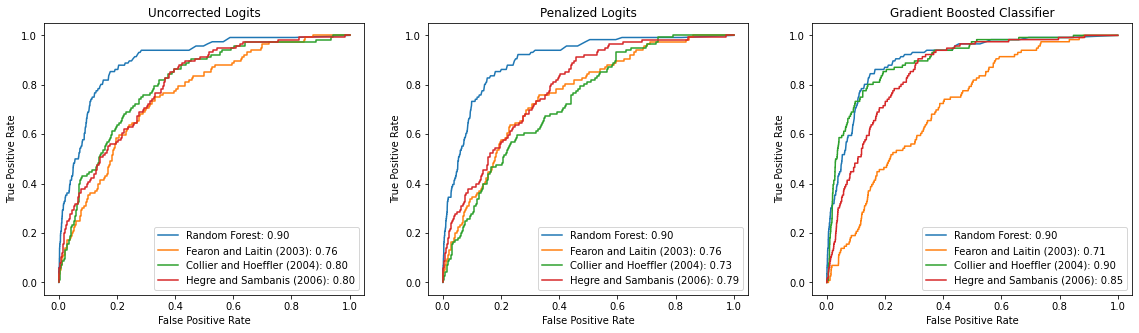

In [13]:
# Methods
titles = ['Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [logistic, logistic_pen, gbc]

# Models
datasets = [X, X_FL, X_CH, X_HS]
models = ['Random Forest', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']


# Fitting models and plotting results            
plot_multi_roc(titles, methods, datasets, models, random_forest, y)

In [16]:
def print_f1_scores(titles, methods, datasets, models, random_forest, y):

    
    for title, method in zip(titles, methods):
        print("F1 score for " + title)
        for X, model in zip(datasets, models):
            scores = cross_val_score(method, X, y, cv=10, scoring='f1')
            print(model + " Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print("===================================")    

In [9]:
# Methods
titles = ['Random Forest', 'Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [random_forest, logistic, logistic_pen, gbc]

# Models
datasets = [X, X_FL, X_CH, X_HS]
models = ['All features', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']

print_f1_scores(titles, methods, datasets, models, random_forest, y)

F1 score for Random Forest
All features Accuracy: 0.10 (+/- 0.18)
Fearon and Laitin (2003) Accuracy: 0.06 (+/- 0.16)
Collier and Hoeffler (2004) Accuracy: 0.23 (+/- 0.18)
Hegre and Sambanis (2006) Accuracy: 0.08 (+/- 0.20)
F1 score for Uncorrected Logits
All features Accuracy: 0.00 (+/- 0.00)
Fearon and Laitin (2003) Accuracy: 0.00 (+/- 0.00)
Collier and Hoeffler (2004) Accuracy: 0.00 (+/- 0.00)
Hegre and Sambanis (2006) Accuracy: 0.03 (+/- 0.12)
F1 score for Penalized Logits
All features Accuracy: 0.00 (+/- 0.00)
Fearon and Laitin (2003) Accuracy: 0.00 (+/- 0.00)
Collier and Hoeffler (2004) Accuracy: 0.00 (+/- 0.00)
Hegre and Sambanis (2006) Accuracy: 0.00 (+/- 0.00)
F1 score for Gradient Boosted Classifier
All features Accuracy: 0.28 (+/- 0.30)
Fearon and Laitin (2003) Accuracy: 0.06 (+/- 0.14)
Collier and Hoeffler (2004) Accuracy: 0.29 (+/- 0.28)
Hegre and Sambanis (2006) Accuracy: 0.12 (+/- 0.27)


TODO acknowledge similarity of results and justify minor differences

## 3. Resampling data with SMOTE

One of our proposals is to use resampling techniques and study their effect on both the linear models and the random forest techniques. Indeed, it may well be that the poor performance of linear models relative to random forest is due to the severe imbalance of the CWD (roughly a 1:100 ratio).
To tackle this, we intend to use one of the most commonly used oversampling methods: the SMOTE (Synthetic Minority Oversampling Technique).

TODO how is SMOTE implemented

In [14]:
# TODO trying imblearn package
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(random_state=2)
X_res, y_res = sm.fit_sample(X, y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

Before OverSampling, counts of label '1': 116
Before OverSampling, counts of label '0': 7024 

After OverSampling, the shape of train_X: (14048, 90)
After OverSampling, the shape of train_y: (14048,) 

After OverSampling, counts of label '1': 7024
After OverSampling, counts of label '0': 7024


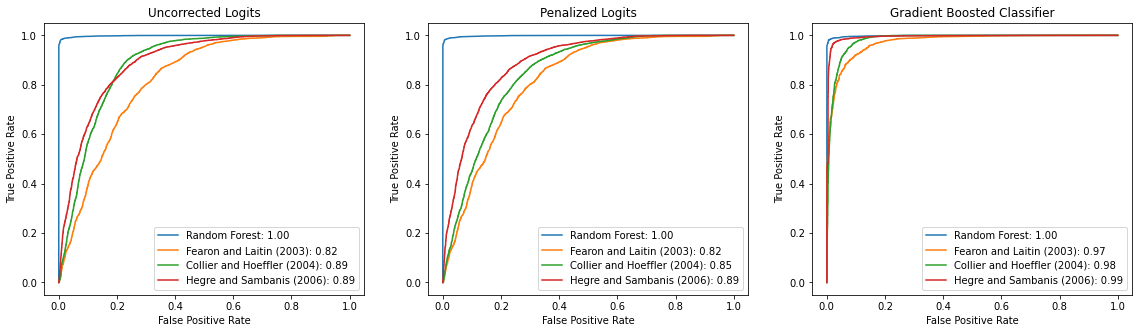

In [15]:
# TODO make a function
#Fearon and Laitin (2003) 
X_FL_res = X_res[FL_features]

#Collier and Hoeffler (2004)
X_CH_res = X_res[CH_features]

#Hegre and Sambanis (2006) 
X_HS_res = X_res[HS_features]


# Creating the methods anew
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
random_forest = RandomForestClassifier(n_estimators=1000)

# Methods
titles = ['Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [logistic, logistic_pen, gbc]

# Models
datasets = [X_res, X_FL_res, X_CH_res, X_HS_res]
models = ['Random Forest', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']

# Fitting models and plotting results            
plot_multi_roc(titles, methods, datasets, models, random_forest, y_res)

In [ ]:
# Methods
titles = ['Random Forest', 'Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [random_forest, logistic, logistic_pen, gbc]

# Models
datasets = [X_res, X_FL_res, X_CH_res, X_HS_res]
models = ['All features', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']

print_f1_scores(titles, methods, datasets, models, random_forest, y_res)

F1 score for Random Forest
All features Accuracy: 0.98 (+/- 0.03)
Fearon and Laitin (2003) Accuracy: 0.90 (+/- 0.06)
Collier and Hoeffler (2004) Accuracy: 0.96 (+/- 0.03)
Hegre and Sambanis (2006) Accuracy: 0.98 (+/- 0.03)
F1 score for Uncorrected Logits
All features Accuracy: 0.79 (+/- 0.06)
Fearon and Laitin (2003) Accuracy: 0.75 (+/- 0.06)
Collier and Hoeffler (2004) Accuracy: 0.83 (+/- 0.04)
Hegre and Sambanis (2006) Accuracy: 0.82 (+/- 0.04)
F1 score for Penalized Logits
All features Accuracy: 0.79 (+/- 0.05)
Fearon and Laitin (2003) Accuracy: 0.75 (+/- 0.06)
Collier and Hoeffler (2004) Accuracy: 0.79 (+/- 0.06)
Hegre and Sambanis (2006) Accuracy: 0.82 (+/- 0.04)
F1 score for Gradient Boosted Classifier
All features Accuracy: 0.98 (+/- 0.03)
Fearon and Laitin (2003) Accuracy: 0.91 (+/- 0.04)


In [16]:
X_res

,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,polch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,12,0.005151,118.554791,129472.904200,121.087366,72.881375,4508.131692,0,0,0,...,0.169350,0.313143,0.373714,0.052989,61.493014,0,0,0,0,1.432991e-01
1,24,0.000000,117.756342,129413.022500,121.885359,72.900089,4491.340308,0,0,0,...,0.000000,1.000000,0.000000,0.052663,100.000000,0,0,0,0,1.000000e+00
2,36,0.000000,118.280656,130431.014500,122.780608,72.962880,4484.267686,0,0,0,...,0.000000,1.000000,0.000000,0.052891,100.000000,0,0,0,0,1.000000e+00
3,48,0.000000,118.325869,126781.686600,118.256427,73.102449,4474.082672,0,0,0,...,0.000000,1.000000,0.000000,0.052902,100.000000,0,0,0,0,1.000000e+00
4,60,0.000000,118.312296,130979.247000,122.245074,72.850389,4497.299503,0,0,0,...,0.000000,1.000000,0.000000,0.052706,100.000000,0,0,0,0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14043,211,0.000000,19.376842,788000.000000,282.708877,47.872236,3346.713343,0,0,0,...,0.828255,0.171745,0.000000,0.022162,34.617694,0,0,0,0,1.755902e-22
14044,201,0.000000,62.712492,15000.000000,29.509222,17.662976,2612.661196,0,0,0,...,1.000000,0.000000,0.000000,0.022573,49.000000,0,0,0,0,1.224594e-03
14045,301,0.000000,86.020126,483000.000000,395.028709,19.950439,2756.324731,0,0,0,...,0.263052,0.328009,0.249203,0.001061,47.131851,0,1,0,0,1.000000e+00
14046,201,0.000000,53.268915,182241.316079,136.130268,27.093425,1884.911631,0,0,0,...,1.000000,0.000000,0.000000,0.021455,43.483762,0,0,0,0,3.008425e-03
